In [1]:
import torch, torchvision
from torchvision import datasets, transforms
import numpy as np
from torch.nn import *
from torch.optim import Adam
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_set = datasets.FashionMNIST(root='/data', train=True, download=True, 
                                  transform = transforms.Compose([transforms.ToTensor()]))
valid_set = datasets.FashionMNIST(root='/data', train=False, download=True, 
                                  transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=512, shuffle=False)

In [4]:
sample = next(iter(train_dl))
x, y = sample
print(f"Training data single batch shape: {x.shape}")
print(f"Training labels single batch shape: {y.shape}")

Training data single batch shape: torch.Size([512, 1, 28, 28])
Training labels single batch shape: torch.Size([512])


In [5]:
batch_sample = next(iter(valid_dl))

In [6]:
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [7]:
def show_data(data_sample):
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(data_sample[0][i].numpy().reshape(28, 28), cmap='gray')
        plt.title(f'Label: {labels[int(data_sample[1][i].item())]}')
        plt.xticks(()); plt.yticks(())

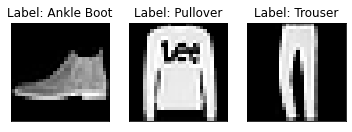

In [8]:
show_data(batch_sample)

<class 'list'>


([], <a list of 0 Text major ticklabel objects>)

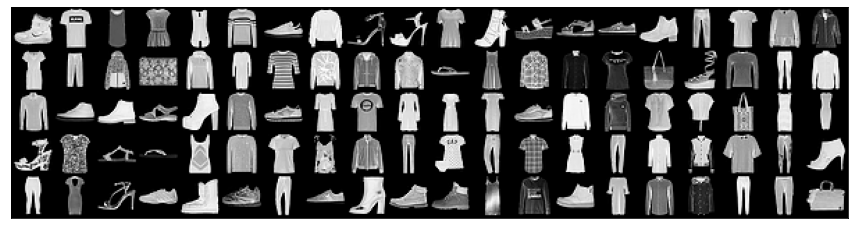

In [9]:
train_loader_2 = torch.utils.data.DataLoader(train_set, batch_size=100)
batch = next(iter(train_loader_2))
print(type(batch))
images, labels = batch
grid_2 = torchvision.utils.make_grid(images, nrow=20) # 20 images in each row: 100:20 = 5 rows in total
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid_2, (1,2,0)), cmap='gray')
plt.xticks(()); plt.yticks(())

In [10]:
class CNNModel(Module):
    
    def __init__(self, start_filter, out, dr=0.2):
        super(CNNModel, self).__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=start_filter, kernel_size=5, padding=2, stride=1)
        self.bn1 = BatchNorm2d(start_filter)
        self.conv2 = Conv2d(in_channels=start_filter, out_channels=start_filter*2, kernel_size=3, padding=1, stride=1)
        self.bn2 = BatchNorm2d(start_filter*2)
        self.conv3 = Conv2d(in_channels=start_filter*2, out_channels=start_filter*4, kernel_size=3, padding=1, stride=1)
        self.bn3 = BatchNorm2d(start_filter*4)
        self.mp = MaxPool2d(kernel_size=2, stride=2)
        self.act = PReLU()
        self.dr = Dropout(dr)
        self.dense1 = Linear(in_features=start_filter*4*3*3, out_features=128)
        self.out = Linear(in_features=128, out_features=out)
        
    def forward(self, inp):
        
        x = self.mp(self.act(self.bn1(self.conv1(inp))))
        x = self.mp(self.act(self.bn2(self.conv2(x))))
        x = self.dr(x)
        x = self.mp(self.act(self.bn3(self.conv3(x))))
        x = self.act(self.dense1(x.view(x.size(0), -1)))
        x = self.out(x)
        
        return x
    
model = CNNModel(start_filter=16, out=10)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): PReLU(num_parameters=1)
  (dr): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=576, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
epochs, loss_fn, optimizer = 10, CrossEntropyLoss(), Adam(model.parameters(), lr=0.003)

In [12]:
for epoch in range(epochs):
    
    loss_history, acc_history = [], []
    total_loss, total_correct = 0, 0

    for x, y in train_dl:
        
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = loss_fn(preds, y)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    for x, y in valid_dl:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = loss_fn(preds, y)
        total_loss += loss.item()
        total_correct += preds.argmax(dim=1).eq(y).sum().item()
        loss_history.append(loss.item())
        acc_history.append((total_correct/len(valid_set)))
    
    print(f"Epoch: {epoch+1:03d} | Loss: {loss:.3f} | Accuracy: {total_correct/len(valid_set)*100:.3f}%")       

Epoch: 001 | Loss: 0.305 | Accuracy: 86.420%
Epoch: 002 | Loss: 0.256 | Accuracy: 87.010%
Epoch: 003 | Loss: 0.206 | Accuracy: 89.800%
Epoch: 004 | Loss: 0.207 | Accuracy: 89.600%
Epoch: 005 | Loss: 0.232 | Accuracy: 90.720%
Epoch: 006 | Loss: 0.198 | Accuracy: 90.630%
Epoch: 007 | Loss: 0.225 | Accuracy: 90.420%
Epoch: 008 | Loss: 0.239 | Accuracy: 91.120%
Epoch: 009 | Loss: 0.211 | Accuracy: 91.060%
Epoch: 010 | Loss: 0.261 | Accuracy: 90.810%


In [13]:
loss_history

[0.23043814301490784,
 0.3016539216041565,
 0.25813573598861694,
 0.2829899489879608,
 0.2509048581123352,
 0.3961372375488281,
 0.37500977516174316,
 0.3435779809951782,
 0.24495428800582886,
 0.28425341844558716,
 0.32416996359825134,
 0.2538277506828308,
 0.21000339090824127,
 0.28305643796920776,
 0.16742147505283356,
 0.22543655335903168,
 0.24605688452720642,
 0.3238084614276886,
 0.23981255292892456,
 0.2605594992637634]

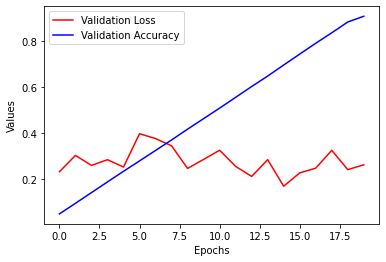

In [14]:
plt.plot(range(len(loss_history)), loss_history, c='r', label='Validation Loss')
plt.plot(range(len(acc_history)), acc_history, c='b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()